# Session: Model and hyperparameterselection

In this exercise set, you will be introduced to cross validation to perform model and hyperparameterselection, allowing us to tackle over and underfitting. The models used will be regularized linear models, where we will also look at how the two canonical models, the Ridge and Lasso, compare to eachother.

The structure of this notebook is as follows:
1. The holdout method
2. Cross validation and pipelines

## Packages
First, we need to import our standard stuff. Notice that we are not interested in seeing the convergence warning in scikit-learn, so we suppress them for now.

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

%matplotlib inline

# Part 1: The holdout method

To evaluate out of sample performance, we utilize the holdout method. The holdout method entails splitting the data into two parts, one for training/development of your model, and one for testing your models. In this first part, we will look into the simplest holdout method, splitting just once into training and test sets, to get a feel for the method. 

To do this, we will try to predict houseprices using a lot of covariates (or features as they are called in Machine Learning). We are going to work with Kaggle's dataset on house prices, see information [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Kaggle is an organization that hosts competitions in building predictive models.

> **Ex. 1.1** Load the california housing data with scikit-learn using the code below. Now:
> 1. Inspect *cal_house*. How are the data stored?
> 2. Create a pandas DataFrame called *X*, using `data`. Name the columns using `feature_names`.
> 3. Crate a pandas Series called *y* using `target`.

In [2]:
from sklearn.datasets import fetch_california_housing

cal_house = fetch_california_housing()    

### BEGIN SOLUTION
X = pd.DataFrame(data=cal_house['data'], 
                 columns=cal_house['feature_names'])
y = cal_house['target']

### END SOLUTION

> ** (OPTIONAL) Ex. 1.2:** Make a for loop with 10 iterations where you:
> 1. Split the input data into, train (also know as development) and test where the test sample should be one third. Set a new random state for each iteration of the loop, so each iteration makes a different split.
> 2. Further split the training (aka development) data into two even sized bins; the first data is for training models and the other is for validating them. Therefore these data sets are often called training and validation.
> 3. Train a linear regression model with sub-training data. Compute the RMSE for out-of-sample predictions for both the test data  and the validation data. Save the RMSE.
>
> You should now have a 10x2 DataFrame with 10 RMSE from both the test data set and the train data set. Compute descriptive statistics of RMSE for the out-of-sample predictions on test and validation data. Are they similar?    
>   They hopefuly are pretty simular. This shows us, that we can split the train data, and use this to fit the model. 
> 
> *Hint*: DataFrames have a method called `describe`, which is handy for computing summary statistics

In [3]:
### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split


def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))
    
output = []

for random_state in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=random_state)    
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=random_state)

    reg = LinearRegression()
    reg.fit(X_train, y_train)

    output.append([rmse(reg.predict(X_val), y_val),
                   rmse(reg.predict(X_test), y_test)])
    
pd.DataFrame(output, columns=['test', 'validation']).describe()
### END SOLUTION

,test,validation
count,10.000000,10.000000
mean,1.121230,1.071124
std,1.066700,0.724296
min,0.723342,0.712719
25%,0.725501,0.726588
50%,0.735969,0.733418
75%,0.737767,0.741826
max,4.122173,2.629215


Having now (hopefully) convinced you that the holdout method works, we return to the full dataset again. We will now look closer at preprocessing and how we can achieve the best out of sample performance using the Lasso.

> **Ex. 1.3:** Split the dataset into a train and test set of equal sizes
> 
> *Hint*: Try importing `train_test_split` from `sklearn.model_selection`

In [4]:
### BEGIN SOLUTION
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1)
### END SOLUTION

Now we have split the data into train/development data and test data, and are ready to start preprocessing our data.



> **Ex. 1.4**: Generate interactions between all features to third degree (make sure you **exclude** the bias/intercept term). How many variables are there? Will OLS fail? After making interactions, rescale the features to have zero mean, unit std. deviation. Should you use the distribution of the training data to rescale the test data?  

> *Hint 1*: Try importing `PolynomialFeatures` from `sklearn.preprocessing`

> *Hint 2*: If in doubt about which distribution to scale, you may read [this post](https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i).

In [5]:
### BEGIN SOLUTION
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# polynomial transformation
poly_trans = PolynomialFeatures(degree=3, include_bias=False)
X_train_p = poly_trans.fit_transform(X_train)
X_test_p = poly_trans.fit_transform(X_test)

print(X_train_p.shape)
# X_train has 83 features, and 10320 rows. Because features < rows, OLS would not fail.
# Note that OLS may become computationally intractable before it fails due 
# to quadratic scaling in computation time.

# rescaling data: we use the distribution of the train data
rescaler = StandardScaler().fit(X_train_p)    

# use scaler on polynomial transformed train and test 
X_train2 = rescaler.transform(X_train_p)
X_test2 = rescaler.transform(X_test_p) 
### END SOLUTION

(10320, 164)


With the data preprocessed, we can now estimate our model, namely the Lasso.

> **Ex. 1.5**: Estimate the Lasso model on the rescaled train data set, using values of $\lambda$ in the range from $10^{-4}$ to $10^4$. For each $\lambda$  calculate and save the Root Mean Squared Error (RMSE) for the rescaled test and train data. Take a look at the fitted coefficients for different sizes of $\lambda$. What happens when $\lambda$ increases? Why?

> *Hint 1*: use `logspace` in numpy to create the range.

> *Hint 2*: read about the `coef_` feature [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso).


In [6]:
### BEGIN SOLUTION
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse

output_lasso = []
# 20 values from 10^-4 to 10^4. Default base=10
lambdas = np.logspace(-4, 4, 20)
coefs_lasso = []
for lambda_ in lambdas:
    reg = Lasso(alpha=lambda_, random_state=1)
    reg.fit(X_train2, y_train)
    coefs_lasso.append(reg.coef_)
    output_lasso.append(
        [
            lambda_,
            rmse(reg.predict(X_train2), y_train),
            rmse(reg.predict(X_test2), y_test),
        ]
    )

scores_lasso = pd.DataFrame(output_lasso, columns = ['lambda', 'train mse', 'test mse'])

scores_lasso

# The coefficients shrink towards zero (and become zero) when lambda increases
# See exercise 1.8 for plots showing this
### END SOLUTION

,lambda,train mse,test mse
0,0.000100,0.638063,8.185574
1,0.000264,0.639897,7.861371
2,0.000695,0.645178,5.890058
3,0.001833,0.655694,4.712577
4,0.004833,0.674803,1.799643
5,0.012743,0.713591,0.722398
6,0.033598,0.750877,0.757155
7,0.088587,0.801681,0.808389
8,0.233572,0.846007,0.849758
9,0.615848,1.034708,1.039874


> **(OPTIONAL) Ex. 1.6**: Make a plot with $\lambda$ on the x-axis and the RMSE measures on the y-axis. What happens to RMSE for train and test data as $\lambda$ increases? The x-axis should be log scaled. Which one are we interested in minimizing? 

> Bonus: Can you find the lambda that gives the lowest MSE-test score?

Minimum RMSE = 0.722 found for lambda = 0.0127.


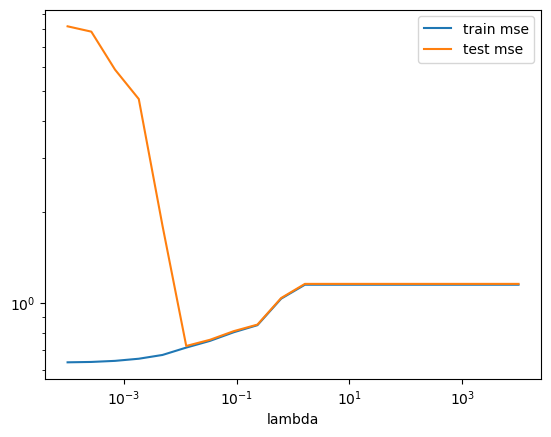

In [7]:
### BEGIN SOLUTION

scores_lasso.set_index("lambda").plot(logx=True, logy=True)

# find the minimal test MSE and associated lambda
idx_best_lambda = scores_lasso['test mse'].idxmin()
best_test_MSE = scores_lasso.iloc[idx_best_lambda]['test mse']
best_lambda = scores_lasso.iloc[idx_best_lambda]['lambda']

print(f"Minimum RMSE = {best_test_MSE:.3f} found for lambda = {best_lambda:.4f}.")
### END SOLUTION

Many different models exist, and trying out multiple and selecting the best is common procedure. Here we implement a Ridge model as well, which requires the same preprocessing.

> **Ex. 1.7**: Repeat the two previous exercises, now estimating the Ridge model instead. Consider the following:
> 1) How does the fitted coefficients differ between the two models?
> 2) Which model performs better? 
> 3) Are you happy with the specified hyperparameterspace?


Minimum RMSE = 0.833 found for lambda = 10000.0000.


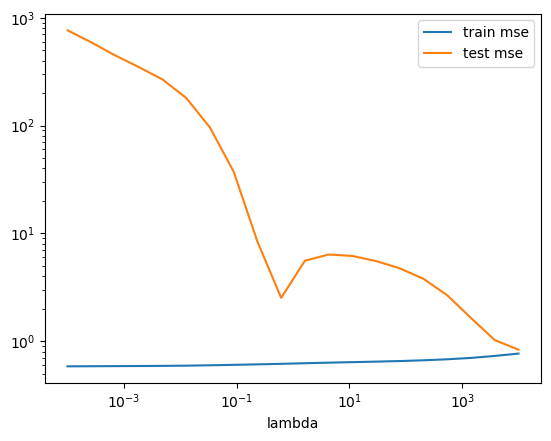

In [8]:
### BEGIN SOLUTION
from sklearn.linear_model import Ridge

output_ridge = []
# 20 values from 10^-4 to 10^4. Default base=10
lambdas = np.logspace(-4, 4, 20)
coefs_ridge = []
for lambda_ in lambdas:
    reg = Ridge(alpha=lambda_, random_state=1)
    reg.fit(X_train2, y_train)
    coefs_ridge.append(reg.coef_)
    output_ridge.append(
        [
            lambda_,
            rmse(reg.predict(X_train2), y_train),
            rmse(reg.predict(X_test2), y_test),
        ]
    )

scores_ridge = pd.DataFrame(output_ridge, columns = ['lambda', 'train mse', 'test mse'])

scores_ridge.set_index("lambda").plot(logx=True, logy=True)

# find the minimal test MSE
idx_best_lambda = scores_ridge['test mse'].idxmin()
best_test_MSE = scores_ridge.iloc[idx_best_lambda]['test mse']
best_lambda = scores_ridge.iloc[idx_best_lambda]['lambda']

# 1) Lasso performs better
print(f"Minimum RMSE = {best_test_MSE:.3f} found for lambda = {best_lambda:.4f}.")
# 2) Ridge is smoother and non-zero, whereas Lasso goes to zero quick
ridge_zero = []
lasso_zero = []

for ridge, lasso in zip(coefs_ridge, coefs_lasso):
    ridge_zero.append(sum(np.isclose(ridge,0)))
    lasso_zero.append(sum(np.isclose(lasso,0)))
# 3) Happy with hyperparameterspace:
# Looks like a corner solution, not optimal!
# But does look to have converged to train mean squared error is equal
# to test mean squared error


As we saw in the geometric interpretation of the minimization objectives, the way the weights behave as a function of $\lambda$.

> **(OPTIONAL) Ex. 1.8**: Create two plots where you lineplot the individual weights as a function of lambda for each value of lambda, one for Lasso and one for Ridge. Does this confirm your earlier conclusions?

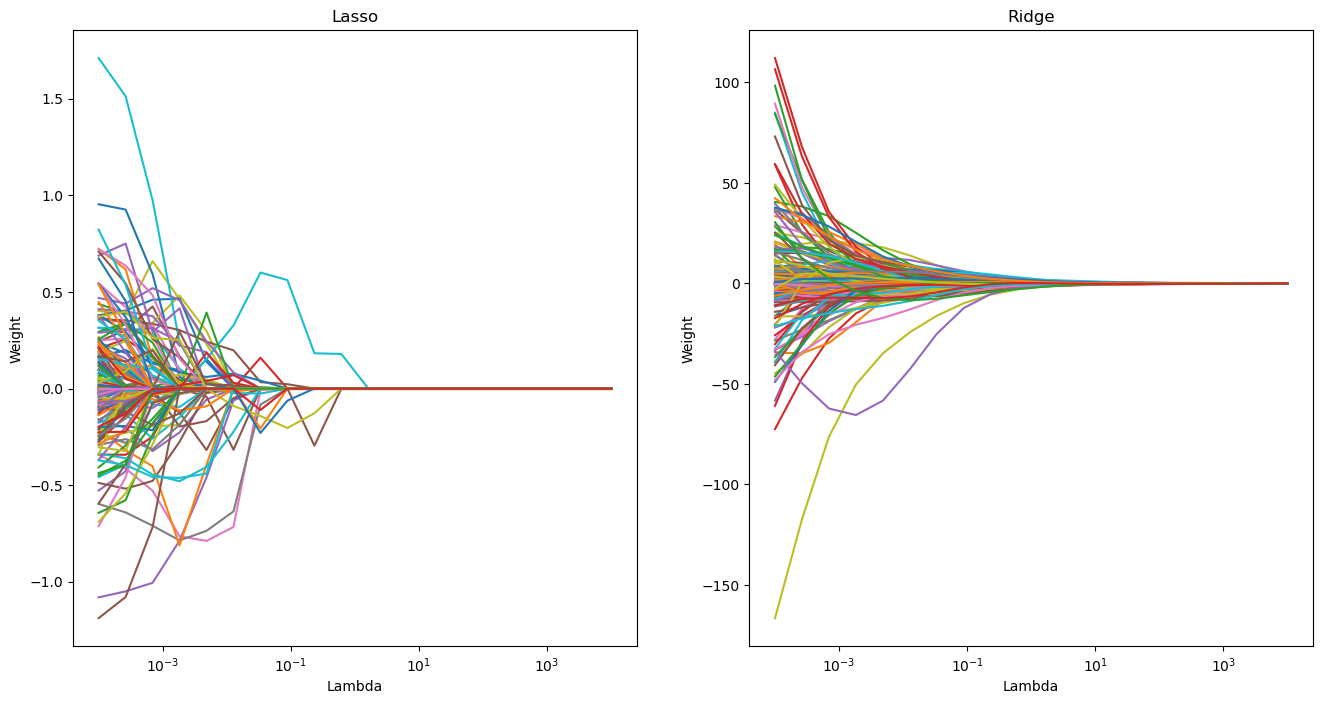

In [9]:
### BEGIN SOLUTION

fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(lambdas, coefs_lasso)
ax[0].set_xscale('log')
ax[0].set_xlabel('Lambda')
ax[0].set_ylabel('Weight')
ax[0].set_title('Lasso')

ax[1].plot(lambdas, coefs_ridge)
ax[1].set_xscale('log')
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('Weight')
ax[1].set_title('Ridge')
plt.show()

# Ridge is smoother and non-zero, whereas Lasso goes to zero

### END SOLUTION

# Part 2: Cross validation and pipelines

In machine learning, we have two types of parameters: those that are learned from
the training data, for example, the weights in linear regression, and the parameters
of a learning algorithm that are optimized separately. The latter are the tuning
parameters, also called *hyperparameters*, of a model. These could for example be the regularization parameter in a regularized linear regression, but also the depth parameter of a decision tree, which we will look into later.

Below, we investigate how we can choose optimal hyperparameters using cross validation using pipelines.

In what follows, we will regard the "train" (aka. development, non-test) data for two purposes. 
- First we are interested in getting a credible measure of models under different hyperparameters to perform a model selection. 
- Then - with the selected model - we estimate/train it on all the training data. 

A powerful tool for making and applying models are pipelines, which allows to combine different preprocessing and model procedures into one. This has many advantages, mainly being more safe but also has the added side effect being more code-efficient.

> **Ex. 2.1:** Construct a model building pipeline which: 
> 1. adds polynomial features of degree 3 without bias;
> 2. scales the features to mean zero and unit std. 

> *Hint:* a modelling pipeline can be constructed with `Pipeline` from `sklearn.pipeline`.

In [10]:
### BEGIN SOLUTION
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

pipe_prep = Pipeline([
    ('pol_features', PolynomialFeatures(degree=3, include_bias=False)),                           
    ('scaler', StandardScaler())
    ]
    )
### END SOLUTION

If we know what model we want to implement, we can also include it in our pipeline. Try it out!m

> **Ex. 2.2:** Construct a model building pipeline which 
> 1. adds polynomial features of degree 3 without bias;
> 2. scales the features to mean zero and unit std. 
> 3. estimates a Lasso model

In [11]:
### BEGIN SOLUTION
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

pipe_lasso = Pipeline([
    ('pol_features', PolynomialFeatures(degree=3, include_bias=False)),                           
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=1))
    ]
    )
### END SOLUTION

## K fold cross validation

The simple validation procedure that we used above has one disadvantage: it only uses parts of the *development* data for validation. To avoid this issue, we can utilize *K* fold cross validation.


When we want to optimize over both normal parameters and hyperparameters, we do this using nested loops (two-layered cross validation). In the outer loop, we vary the hyperparameters, and then in the inner loop, we do cross validation for the model with the specific selection of hyperparameters. This way, we can find the model with the lowest mean MSE. 

> **(OPTIONAL) Ex. 2.3:**
Run a Lasso regression using the Pipeline from `Ex 2.2`. In the outer loop, search through the lambdas specified below. 
In the inner loop, make *5 fold cross validation* on the selected model and store the average MSE for each fold. Which lambda, from the selection below, gives the lowest test MSE?
>  ```python 
> lambdas =  np.logspace(-4, 4, 10)
> ```
> *Hint:* `KFold` in `sklearn.model_selection` may be useful.

In [12]:
### BEGIN SOLUTION
from sklearn.model_selection import KFold

lambdas =  np.logspace(-4, 4, 10)

kfolds = KFold(n_splits=5)
mses = []

for lambda_ in lambdas:

    pipe_lasso = Pipeline([
            ('pol_features', PolynomialFeatures(degree=3, include_bias=False)),                           
            ('scaler', StandardScaler()),
            ('lasso', Lasso(alpha=lambda_, random_state=1))
            ]
        )
        
    mses_test = []
    mses_train = []

    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx]

        pipe_lasso.fit(X_train, y_train)

        mses_train.append(mse(pipe_lasso.predict(X_train), y_train))
        mses_test.append(mse(pipe_lasso.predict(X_val), y_val))

    mses.append([np.mean(mses_train), np.mean(mses_test), lambda_])

# Create df with MSE values
df_mses = pd.DataFrame(mses, columns=["MSE_train", "MSE_test", "lambda"])

# Index of the lambda that gives the lowest MSE_test in the dataframe
idx_optimal_lambda = df_mses.idxmin()["MSE_test"]
lambda_opt_test = df_mses.loc[idx_optimal_lambda]["lambda"]
opt_test_mse = df_mses.loc[idx_optimal_lambda]["MSE_test"]
print(
    f"Lowest test MSE equal to {opt_test_mse:.4f} is"
    f" achieved with lambda = {lambda_opt_test:.5f}."
)

Lowest test MSE equal to 0.5939 is achieved with lambda = 0.04642.


When you have *more than one* hyperparameter, you will want to fit the model to all the possible combinations of hyperparameters. This is done in an approch called `Grid Search`, which is implementet in `sklearn.model_selection` as `GridSearchCV`.

However, this is also very useful when you only have one hyperparameter, as it removes a lot of the boilerplate code.

> **Ex. 2.4:** To get to know `Grid Search`, we want to implement it in one dimension. Using `GridSearchCV`, implement the Lasso pipeline, with the same lambdas as before (`lambdas =  np.logspace(-4, 4, 10)`), 5-fold CV and (negative) mean squared error as the scoring variable. Which value of $\lambda$ gives the lowest test error? 

In [13]:
### BEGIN SOLUTION

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator=pipe_lasso, 
                  param_grid=[{'lasso__alpha':lambdas}], 
                  scoring='neg_mean_squared_error', 
                  cv=5, 
                  n_jobs=-1)

gs = gs.fit(X_dev, y_dev)
print(gs.best_params_)

lasso_best_lambda = gs.best_params_['lasso__alpha']

### END SOLUTION

{'lasso__alpha': 0.046415888336127774}


> **(OPTIONAL) Ex. 2.5** Now set `lambdas =  np.logspace(-4, 4, 100)`, and repeat the previous exercise now with RandomizedSearchCV with `n_iter=12`. What's the difference between the two gridsearches?

In [14]:
from sklearn.model_selection import RandomizedSearchCV

# BEGIN SOLUTION

lambdas_new = np.logspace(-4, 4, 100)

gs = RandomizedSearchCV(estimator = pipe_lasso,
                                param_distributions = [{"lasso__alpha": lambdas_new}], 
                                cv = 10, 
                                scoring = "neg_mean_squared_error",
                                n_iter = 12,
                                random_state=1)

gs.fit(X_dev,y_dev)

print(gs.best_params_)

### END SOLUTION

{'lasso__alpha': 0.04641588833612782}


We will now use the search functions with more than one hyperparameter, displaying their flexibility and power. 

To do this, we need a model with more than one hyperparameter. The Elastic Net is one such example, which has two hyperparameters. The first hyperparametes determines how much to regularize, and the second determins how to weigh between Lasso and Ridge regularization.

> **(OPTIONAL) Ex. 2.6** Implement an Elastic Net using `RandomizedSearchCV` with `n_iter=10` and the previous lambda values.
> >
> *Hints*:
> - Try using `np.linspace` to create linearly spaced hyperparameters.
> - Try importing `ElasticNet` from `sklearn.linear_model`.
> - The documentation for `ElasticNet` has information on the hyperparameters and their exact names.

In [15]:
### BEGIN SOLUTION
from sklearn.linear_model import ElasticNet

pipe_elastic = Pipeline([
    ('pol_features', PolynomialFeatures(degree=3, include_bias=False)),                           
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(random_state=1))
    ]
    )

lambdas_new = np.logspace(-4, 4, 100)
l1_ratio = np.linspace(0,1, 10)

gs = RandomizedSearchCV(estimator = pipe_elastic,
                                param_distributions = {"elasticnet__alpha": lambdas_new,
                                                    "elasticnet__l1_ratio": l1_ratio}
                                                    , 
                                cv = 10, 
                                scoring = "neg_mean_squared_error",
                                n_iter = 10,
                                random_state=1)

gs.fit(X_dev,y_dev)

print(gs.best_params_)

gs.score(X_test,y_test)
### END SOLUTION

{'elasticnet__l1_ratio': 0.5555555555555556, 'elasticnet__alpha': 0.007220809018385471}


-29.681336441916752

## Tools for model selection

Below we review two useful tools for performing model selection. The first tool, the learning curve, can be used to assess whether there is over- and underfitting.

> **(OPTIONAL) Ex. 2.7** __Learning curves__
> 
> Create a learning curve using 5 fold cross validation and the $\lambda$ found in exercise 2.4. What does it tell you about over- and underfitting?
>
> *Hint*: Try importing `learning_curve` from `sklearn.model_selection`.

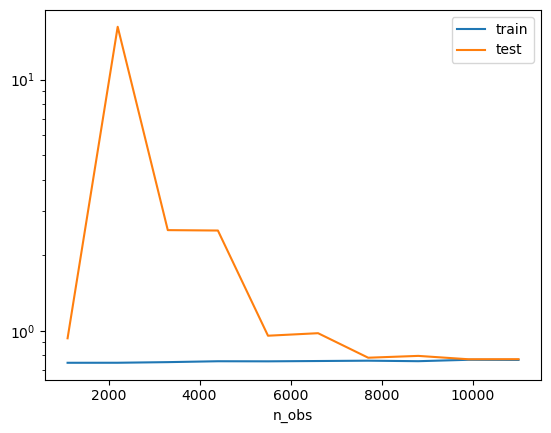

In [16]:
### BEGIN SOLUTION

from sklearn.model_selection import learning_curve

pipe_lasso = Pipeline([
            ('pol_features', PolynomialFeatures(degree=3, include_bias=False)),                           
            ('scaler', StandardScaler()),
            ('lasso', Lasso(alpha=lasso_best_lambda, random_state=1))
            ]
        )

lambdas =  np.logspace(-4, 4, 10)

n_obs, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     train_sizes=np.linspace(0.1,1,10),
                     scoring='neg_mean_squared_error',# scoring='neg_mean_squared_error',                 
                     cv=5)

mean_values = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
                         'test': pd.DataFrame(-test_scores).mean(1), 
                         'n_obs': pd.DataFrame(n_obs).mean(1)}, axis =1)

pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(n_obs, name='n_obs'))\
    .plot(logy=True)

plt.show()

# As the train and validation mean squared error stabilize and have a relatively small gap by the end, we have a well fit model 
### END SOLUTION

> **(OPTIONAL) Ex.2.8:** __Automated Cross Validation in one dimension__  
When you are doing cross validation with one hyperparameter, you can automate the process by using `validation_curve` from `sklearn.model_selection` and easily plot validation curves afterwards. Use this function to search through the values of lambdas, and find the value of lambda, which gives the lowest test error.  

In [17]:
### BEGIN SOLUTION

from sklearn.model_selection import validation_curve

pipe_lasso = Pipeline([
            ('pol_features', PolynomialFeatures(degree=3, include_bias=False)),                           
            ('scaler', StandardScaler()),
            ('lasso', Lasso(random_state=1))
            ]
        )

lambdas =  np.logspace(-4, 4, 10)

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',              
                     cv=5)

mean_values = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
                         'test': pd.DataFrame(-test_scores).mean(1), 
                         'lambda': pd.DataFrame(lambdas).mean(1)}, axis =1)

mean_values
### END SOLUTION

,train,test,lambda
0,0.400460,41.162396,0.000100
1,0.412454,2.015578,0.000774
2,0.455627,0.838400,0.005995
3,0.585684,0.593914,0.046416
4,0.811365,0.812094,0.359381
5,1.323110,1.323249,2.782559
6,1.323110,1.323249,21.544347
7,1.323110,1.323249,166.810054
8,1.323110,1.323249,1291.549665
9,1.323110,1.323249,10000.000000



> **(OPTIONAL) Ex. 2.9:** Plot the average MSE-test and MSE-train (validation curve) against the different values of lambda. Does this differ from the one in exercise 1.6? If yes, why?
> 
> *Hints*: 
> - Use logarithmic axes, and lambda as index
> - Have you done the same sample splitting in this and exercise 1.6?

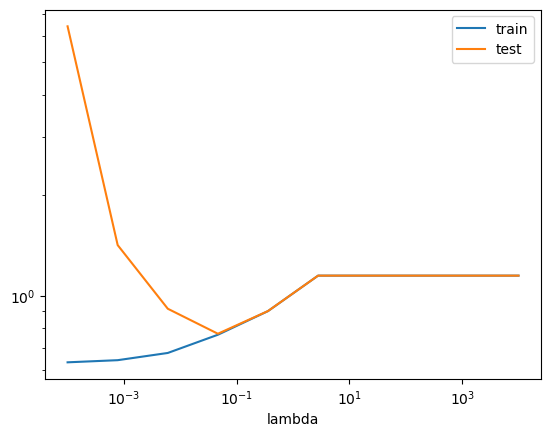

In [18]:
### BEGIN SOLUTION

from sklearn.metrics import mean_squared_error as mse

# plot curves
pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(lambdas, name='lambda'))\
    .plot(logx=True, logy=True)

plt.show()

# It does differ for two reasons:
# 1) this implementation uses 5 fold cross validation, whereas exercise 1.6 used only holdout
# 2) In 1.6 we use the full train/development dataset to train on and plot out of sample using the test dataset. 
# This cannot be used for model selection, as we must NEVER use the test set for model selection.
# In this exercise, we use cross validation to split the dataset into train and validation sets.
# This allows us to do model selection without using the test set.
### END SOLUTION